### Àlex Correa Orri 1564967

#### Dataset: https://www.kaggle.com/shaurov/website-classification-using-url

In [33]:
#reset()

### MÒDULS I LLIBRERIES

In [34]:
import pandas as pd
import time
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline 
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn import tree
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from sklearn.pipeline import Pipeline
from keras.utils import np_utils
import re
from keras.preprocessing import sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import pickle
import os
from nltk.corpus import stopwords

### DIRECTORI DE TREBALL

#### Cal modificar el directori on es troba el dataset en cas que no es trobi al mateix directori que aquest notebook

In [35]:
os.getcwd()
#path = 'C:/Users/alexc/OneDrive/Escritorio/UNI/3er/Aprenentatge Computacional/PRAC_KAGGLE'
#os.chdir(path)
#os.getcwd()

'C:\\Users\\alexc\\OneDrive\\Escritorio\\UNI\\3er\\Aprenentatge Computacional\\PRAC_KAGGLE'

### LECTURA DE DADES

In [36]:
dataset = pd.read_csv('URL_Classification.csv', names=['n', 'url', 'class'], delimiter=',', na_filter=False)

### DATASET I MOTIVACIÓ

#### Dataset que conté 1.6M d'enllaços, cadascún d'ells té assignada a una categoria ('class'). L'objectiu del treball és predir a quina categoria pertany un enllaç o un conjunt d'enllaços donat amb la màxima precisió possible.
#### La classificació de url pot ser molt útil en els següents camps:
- Control parental
- Control d'accès desde un servidor
- Bloqueig de direccions desde un router
- Bloqueig d'amenaces / Antivirus
- Control i detecció d'anuncis o spam
- Classificació automàtica de notícies


In [37]:
dataset

,n,url,class
0,1,http://www.liquidgeneration.com/,Adult
1,2,http://www.onlineanime.org/,Adult
2,3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
3,4,http://www.galeon.com/kmh/,Adult
4,5,http://www.fanworkrecs.com/,Adult
...,...,...,...
1562973,1562974,http://www.maxpreps.com/,Sports
1562974,1562975,http://www.myscore.com/,Sports
1562975,1562976,http://sportsillustrated.cnn.com/highschool,Sports
1562976,1562977,http://rss.cnn.com/rss/si_highschool?format=xml,Sports


In [38]:
print(dataset['class'].unique())
len(dataset['class'].unique())

['Adult' 'Arts' 'Business' 'Computers' 'Games' 'Health' 'Home' 'Kids'
 'News' 'Recreation' 'Reference' 'Science' 'Shopping' 'Society' 'Sports']


15

<AxesSubplot:>

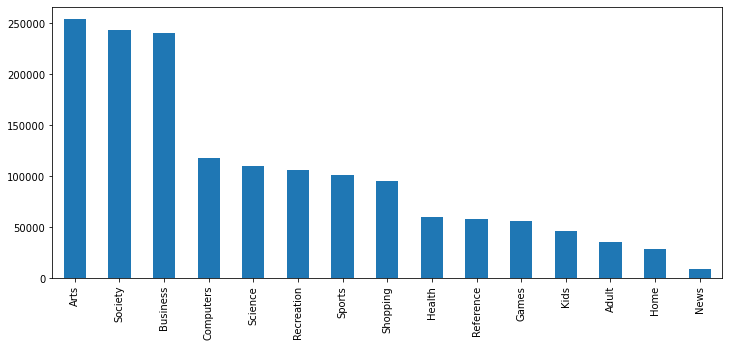

In [39]:
dataset['class'].value_counts().plot(figsize=(12, 5),kind='bar')

#### El dataset conté 15 categories diferents:
- Adult
- Arts
- Business
- Computers
- Games
- Health
- Home
- Kids
- News
- Recreation
- Reference
- Science
- Shopping
- Society
- Sports

### MODIFICACIÓ DEL DATASET

#### Eliminar possibles valor NAN del dataset

In [40]:
dataset=dataset.dropna()

#### Per fer proves més ràpides es pot reduir el dataset a s 'samples' (descomentar següents comandes)

In [41]:
#s=50000
#dataset = dataset.sample(n=s, random_state=10)

#### Consulta sobre quines són les paraules més comunes del dataset

In [42]:
urls=''
for url in dataset['url']:
    urls += url
#urls: text concatenat amb tots els strings (sense espais)

In [43]:
vect = CountVectorizer()
mat = vect.fit_transform([urls])
counts = pd.DataFrame(mat.toarray(), columns=vect.get_feature_names())
counts #pandas dataframe amb els valors de les paraules més comunes al string

,00,000,0000,000000,0000000000000000039176http,0000000000000000044918http,00000000002000000003470010http,0000000023http,0000000045http,0000000053ad,...,zzzfelis,zzzgeminiclubsa,zzzlocalsites,zzzptm,zzzsen9ya7c,zzzuzruzglc,zzzv7313hlc,zzzweb,zzzwnppl,zzzzphoecolontradeposts
0,682,69,11,1,1,1,1,1,1,1,...,1,1,3,2,1,1,1,1,1,1


#### Ngrames més comuns ordenats segons el nombre d'aparicions al dataset

In [44]:
sort_counts = counts.sort_values(by =0, axis=1)
sort_counts = sort_counts[sort_counts.columns[::-1]]
sort_counts #dataframe ordenat per la paraula més comuna

,www,http,com,comhttp,org,htmlhttp,htmhttp,edu,co,uk,...,newyorksurveyrepair,newyorktattoo,newyorkvideoconference,newyorktwistdrill,newyorkultimate,newyorkultrarunning,newyorkun,newyorkunicycle,newyorkvideo,jumpinghfarm
0,1255832,860869,780805,191765,185544,171948,113603,86651,71265,69722,...,1,1,1,1,1,1,1,1,1,1


#### Com era d'esperar les 'paraules' o ngrames més comuns contenen el terme http, com, co, net, org, etc.

In [45]:
sort_counts.iloc[:, : 20].columns

Index(['www', 'http', 'com', 'comhttp', 'org', 'htmlhttp', 'htmhttp', 'edu',
       'co', 'uk', 'net', 'geocities', 'index', 'amp', 'orghttp', 'ca',
       'tripod', 'angelfire', 'au', 'ukhttp'],
      dtype='object')

#### Llista de termes que a priori sembla que no tinguin rellevància amb la categoria de l'enllaç. Es provarà d'eliminar-ho dels url o utilitzar-ho de 'stopwords' pel countvectorizer

In [46]:
stp_w = ['www', 'http', 'com', 'comhttp', 'org', 'htmlhttp', 'htmhttp', 'edu', 'co', 'uk', 'net', 'orghttp','html','nethttp','shtmlhttp', 'ukhttp','dehttp','zahttp','jpghttp']

### SEPARACIÓ TRAIN - TEST

#### Per evitar problemes és millor definir la mida de dades que hi haurà per cada classe al dataset de test.

In [47]:
test_data = []
fraction_sample = 0.05
size_per_class = round(dataset.shape[0]*fraction_sample/15)
for c in dataset['class'].unique():
    test_data.append(dataset[dataset['class'] == c][0:size_per_class])
test_data = pd.concat([test_data[0], test_data[1],test_data[2],test_data[3],test_data[4],test_data[5], test_data[6],test_data[7],test_data[8],test_data[9],test_data[10], test_data[11],test_data[12],test_data[13],test_data[14]], axis=0)

#### Guardem el dataset de test

In [48]:
test_data.to_csv('test_data.csv', index=False)

#### Eliminar del dataset original les mostres de test

In [49]:
for c in dataset['class'].unique():
    f_i = dataset[dataset['class'] == c].index[0]
    l_i = f_i + size_per_class - 1
    dataset.drop(dataset.index[f_i:l_i],inplace= True)
train_data = dataset

#### Quantitat de dades d'entrenament per cada classe, mantenint la proporció del dataset original

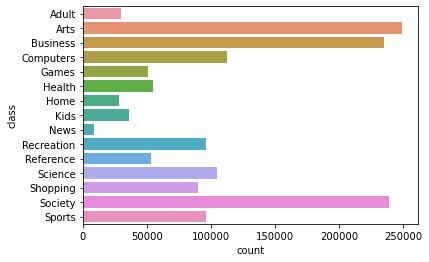

In [50]:
ax = sns.countplot(y = "class",  data = train_data)

In [51]:
train_data.set_index(['class', 'n']).count(level="class")

,url
class,
Adult,30116
Arts,248631
Business,234968
Computers,112753
Games,51268
Health,54888
Home,28269
Kids,35764
News,8989


#### Quantitat de dades de test per cada classe

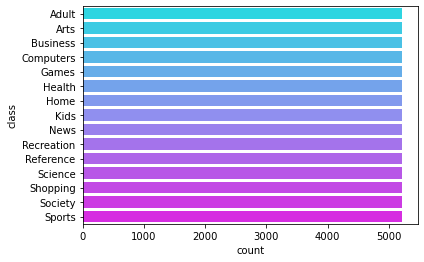

In [52]:
ax = sns.countplot(y = "class",  data = test_data, palette='cool')

#### Separació X i y als dos datasets (test i entrenament)

#### Si es vol reduir la mida d'entrenament i/o del test es pot fer descomentant la comanda que fa el 'train_test_split'. D'aquesta manera també es triarà un dataset diferent en cada execució. Amb el paràmetre stratify es mantindran les proporcions de classes a cada dataset.

In [53]:
X_train=train_data['url']
y_train=train_data['class']
#X_train, x_v, y_train, y_v = train_test_split(X_train, y_train, train_size=0.95, stratify=y_train)

In [54]:
X_test=test_data['url']
y_test=test_data['class']
#X_test, x_v, y_test, y_v = train_test_split(X_test, y_test, train_size=0.95, stratify=y_test)

### CONSTRUCCIÓ DEL MODEL

#### Pipeline Multinomial

- CountVectorizer: crea una matriu (sparse matrix) on les columnes són les paraules (o ngrames) trobades per cada enllaç (cada fila).
- TfidfTransformer: Transforma una 'count matrix' a una representació normalitzada tf o tf-idf. Tf:'term-frequency'; Tf-idf: 'term-frequency times inverse document-frequency'
- MultinomialNB: 'Multinomial Naive Bayes'. Segons sklearn, 'The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification)'
https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

#### La següent configuració d'hiperparàmetres és la que millor resultats ha donat

In [55]:
vectorizer = CountVectorizer(ngram_range=(3,3))
clf = Pipeline([('vect', vectorizer), 
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB(fit_prior=False, alpha = 0.0)),#0.0001
                  ])
#stop_words=stopwords.words('english'), 

#### Entrenament

In [56]:
ti = time.time()
clf = clf.fit(X_train, y_train)
tf = time.time()
print("L'entrenament ha acabat satisfactòriament en "+str(tf-ti)+"s")

L'entrenament ha acabat satisfactòriament en 44.70955276489258s


#### Guardem el model entrenat

In [57]:
filename = 'multinomialNB_trained.sav'
pickle.dump(clf, open(filename, 'wb'))

#### Classificació i precisió del test

In [58]:
y_pred=clf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.9467388489931214, 0.9385924504158669, 0.9357772227941135, None)

#### Precisió de la classificació de cada classe

In [59]:
print(classification_report(y_test, y_pred, digits = 5))

              precision    recall  f1-score   support

       Adult    0.98263   0.71651   0.82873      5210
        Arts    0.88083   0.99021   0.93232      5210
    Business    0.98783   0.98177   0.98479      5210
   Computers    0.97597   0.95106   0.96335      5210
       Games    0.70267   0.99655   0.82419      5210
      Health    0.99026   0.99501   0.99263      5210
        Home    0.96960   0.99789   0.98354      5210
        Kids    0.94195   0.55125   0.69548      5210
        News    0.98761   0.99482   0.99120      5210
  Recreation    0.89897   0.98887   0.94178      5210
   Reference    0.95260   0.97985   0.96603      5210
     Science    0.96743   0.96929   0.96836      5210
    Shopping    0.98856   0.99520   0.99187      5210
     Society    0.98258   0.97409   0.97831      5210
      Sports    0.99160   0.99655   0.99406      5210

    accuracy                        0.93859     78150
   macro avg    0.94674   0.93859   0.93578     78150
weighted avg    0.94674   

#### Heatmap de probabilitats entre la classificació real i la predicció

Text(114.0, 0.5, 'Test/real')

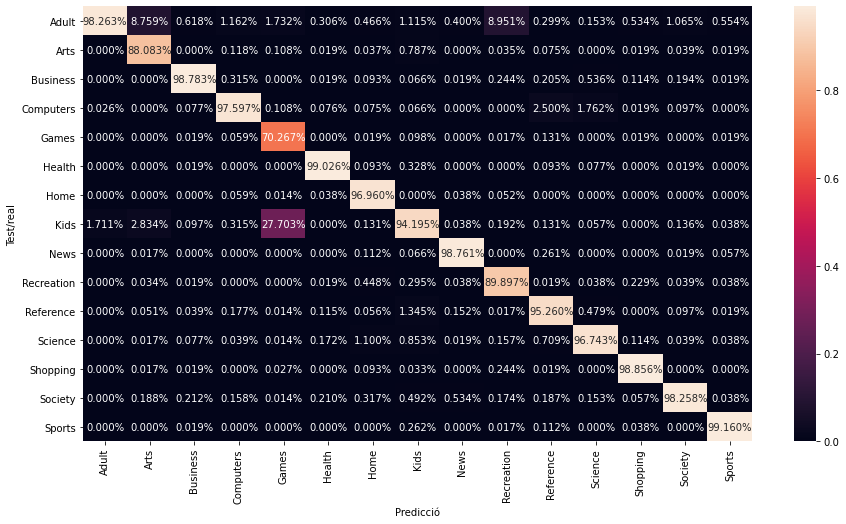

In [60]:
mat = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(mat, index = [i for i in dataset['class'].unique()],
                  columns = [i for i in dataset['class'].unique()])
plt.figure(figsize = (15,8))
sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%')
plt.xlabel('Predicció')
plt.ylabel('Test/real')

### CERCA D'HIPERPARÀMETRES

- CountVectorizer: ngram_range

In [27]:
precision_r = []
for n1 in range(5):
    vectorizer = CountVectorizer(ngram_range=(n1+1,n1+1))
    clf = Pipeline([('vect', vectorizer), 
                       ('tfidf', TfidfTransformer()),
                       ('clf', MultinomialNB(fit_prior=False, alpha = 0.0)),#0.0001
                      ])
    clf = clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    precision_r.append(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0])
print(precision_r)

[0.8646945870286215, 0.9186687953556945, 0.9467388489931214, 0.9263849014471519, 0.8932728733007393]


In [28]:
precision_r = []
for n1 in range(7):
    vectorizer = CountVectorizer(ngram_range=(1,n1+1))
    clf = Pipeline([('vect', vectorizer), 
                       ('tfidf', TfidfTransformer()),
                       ('clf', MultinomialNB(fit_prior=False, alpha = 0.0)),#0.0001
                      ])
    clf = clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    precision_r.append(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0])
print(precision_r)

[0.8646945870286215, 0.9152443796069334, 0.9186640072127995, 0.9194048609987454, 0.9200380866288079, 0.9203854697981215, 0.9204730086474893]


- CountVectorizer: stop_words

In [29]:
precision_r = []
for stp in ['english', stp_w, None]:
    vectorizer = CountVectorizer(stop_words=stp,ngram_range=(3,3))
    clf = Pipeline([('vect', vectorizer), 
                       ('tfidf', TfidfTransformer()),
                       ('clf', MultinomialNB(fit_prior=False, alpha = 0.0)),#0.0001
                      ])
    clf = clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    precision_r.append(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0])
print(precision_r)

[0.9455378492814203, 0.8783017438250544, 0.9467388489931214]


- MultinomialNB: alpha

In [30]:
precision_r = []
for a in np.arange(0.0,1.0,0.1):
    vectorizer = CountVectorizer(ngram_range=(3,3))
    clf = Pipeline([('vect', vectorizer), 
                       ('tfidf', TfidfTransformer()),
                       ('clf', MultinomialNB(fit_prior=False, alpha = a)),
                      ])
    clf = clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    precision_r.append(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0])
print(precision_r)

[0.9467388489931214, 0.9271822589784403, 0.9177203856940828, 0.9096794702289288, 0.9043759839776362, 0.8996675019172798, 0.8965542093246016, 0.8937967505610562, 0.8906860292772234, 0.8884140258773808]


- MultinomialNB: fit_prior (true o false)

In [31]:
precision_r = []
for b in [True, False]:
    vectorizer = CountVectorizer(ngram_range=(3,3))
    clf = Pipeline([('vect', vectorizer), 
                       ('tfidf', TfidfTransformer()),
                       ('clf', MultinomialNB(fit_prior=b, alpha = 0.0)),
                      ])
    clf = clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    precision_r.append(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0])
print(precision_r)

[0.9289328160972107, 0.9467388489931214]
